# **Project 2**, APS1070 Fall 2021
**Anomaly Detection Algorithm using Gaussian Mixture Model [13 Marks]**

**Deadline: OCT 22, 9 PM**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Name: shubowan
*   Student Number: 1007826907

##**Part 1: Getting started [1.5 Marks]**

We are going to work with a credit card fraud dataset. This dataset contains 28 key features, which are not 
directly interpretable but contain meaningful information about the dataset.

Load the dataset in CSV file using Pandas. The dataset is called `creditcard.csv`. Print out the first few columns of the dataset.

* How many rows are there? 284807 **[0.1]**
* What features in the dataset are present aside from the 28 main features?  time and amount **[0.1]**
* Which column contains the targets? Class **[0.1]**
* To what do the target values correspond? credit card fraud or not **[0.1]**

In [ ]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=98fd851792840b46bddfadecc8f84443bad7529528b60500ac1fea9788f65457
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [ ]:
import wget

wget.download('https://github.com/aps1070-2019/datasets/raw/master/creditcard.tar.gz','creditcard.tar.gz')

'creditcard.tar.gz'

In [ ]:
!tar -zxvf creditcard.tar.gz

creditcard.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
df = pd.read_csv('creditcard.csv')

In [ ]:
### YOUR CODE HERE ###
print(df.head(10))
print(df.shape)
print(df['Class'].unique())

   Time        V1        V2        V3  ...       V27       V28  Amount  Class
0   0.0 -1.359807 -0.072781  2.536347  ...  0.133558 -0.021053  149.62      0
1   0.0  1.191857  0.266151  0.166480  ... -0.008983  0.014724    2.69      0
2   1.0 -1.358354 -1.340163  1.773209  ... -0.055353 -0.059752  378.66      0
3   1.0 -0.966272 -0.185226  1.792993  ...  0.062723  0.061458  123.50      0
4   2.0 -1.158233  0.877737  1.548718  ...  0.219422  0.215153   69.99      0
5   2.0 -0.425966  0.960523  1.141109  ...  0.253844  0.081080    3.67      0
6   4.0  1.229658  0.141004  0.045371  ...  0.034507  0.005168    4.99      0
7   7.0 -0.644269  1.417964  1.074380  ... -1.206921 -1.085339   40.80      0
8   7.0 -0.894286  0.286157 -0.113192  ...  0.011747  0.142404   93.20      0
9   9.0 -0.338262  1.119593  1.044367  ...  0.246219  0.083076    3.68      0

[10 rows x 31 columns]
(284807, 31)
[0 1]



* What is the percentage of entries in the dataset for each class? 1:0.173% 0:99.827% **[0.1]**
* Is this data considered balanced or unbalanced? Why is this the case? unbalanced data,because non-fraud cases is much more than fraud case **[0.1]**
* Why is balance/imbalance important? How might this class ditribution affect a KNN classifier for example, which we explored in Project 1? Imbalance data may cause machine learning model more biased towards the major classes and cause poor classification of minority classes.  We request high accuracy from KNN and with imbalanced data, high accuracy doesn't means good performance. KNN can predict all data as non-fraud and get 99% accuracy but it's meaningless**[0.2]**



In [ ]:
### YOUR CODE HERE ###
print('percentage of 1:',sum(df['Class'])*100/df.shape[0],'%')
print('percentage of 0:',(df.shape[0]-sum(df['Class']))*100/df.shape[0],'%')

percentage of 1: 0.1727485630620034 %
percentage of 0: 99.827251436938 %


Next, split the dataset into a training (70%), validation (15%) and testing set (15%). Set the random state to 0. **[0.2]**

Make sure to separate out the column corresponding to the targets.

In [ ]:
### Split the data  ###

X_train, X_val, X_test, y_train, y_val, y_test = 0, 0, 0, 0, 0, 0
X0=df.values[:,0:30]
y0=df.values[:,30]
X_train,X,y_train,y=train_test_split(X0,y0,train_size=0.7,random_state=0)
X_val,X_test,y_val,y_test=train_test_split(X,y,train_size=0.5,random_state=0)
df_X_train=pd.DataFrame(data=X_train,columns=df.columns[0:30])

Now, let's take a look at the difference in distribution for some variables between fraudulent and non-fraudulent transactions:

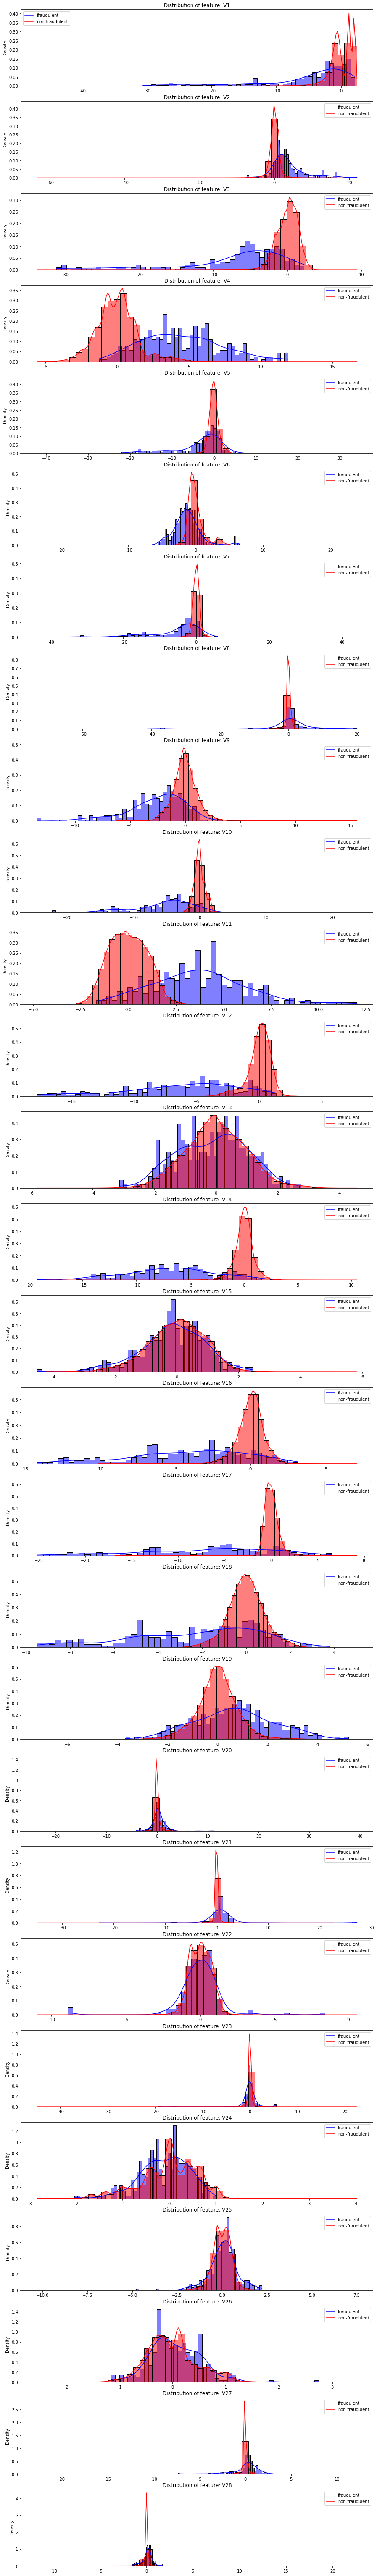

In [ ]:
import matplotlib.gridspec as gridspec
features=[f for f in df.columns if 'V' in f]
nplots=np.size(features)
plt.figure(figsize=(15,4*nplots))
gs = gridspec.GridSpec(nplots,1)
for i, feat in enumerate(features):
    ax = plt.subplot(gs[i])
    sns.histplot(df_X_train[feat][y_train==1], stat="density", kde=True, color="blue", bins=50)
    sns.histplot(df_X_train[feat][y_train==0], stat="density", kde=True, color="red", bins=50)
    ax.legend(['fraudulent', 'non-fraudulent'],loc='best')
    ax.set_xlabel('')
    ax.set_title('Distribution of feature: ' + feat)

Explain how these graphs could provide meaningful information about anomaly detection using a gaussian model. **[0.5]**
We can see which features have most different distributions between fraud and non-fraud data. The less overlap of the Gaussian distribution of the two classes, the feature has more ability to classify the samples. These kinds of features always have higher f1 and features whose distributions ovelap much cannot tell the differences between two classes.  Also, we can find that non_fraud data often obey one gaussian distribution and fraud data may have more than one distributions in one feature.

## **Part 2: Single feature model with one Gaussian distribution: [2.5 Marks]**
We'll start by making a prediction using **a single feature of our dataset at a time**. 

Please note that we **only use `V` features** in our model.

**a. Fitting regardless of class:**
  1. Fit a single Gaussian distribution on a single feature of **the full training dataset** (both classes) using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. 
  2. Compute AUC (Area under the ROC Curve) based on ``sklearn.mixture.GaussianMixture.score_samples`` on both the full training set and validation set (including both classes).  
  3. Repeat the above steps for each of the features and present your findings in a table. 
  4. Find the best 3 features to distinguish fraudulent transactions from non-fraudulent transactions based on the AUC of the validation set. **[0.2]**
  V14 V10 V4
  5. Make a prediction based on a model's scores: If the `score_samples` is lower than a threshold, we consider that transaction as a fraud. Find an optimal threshold that maximizes the F1 Score of the validation set for each of those 3 features separately. (Do not check every possible value for threshold, come up with a faster way!) Compute F1 score using `sklearn.metrics.f1_score`. **[0.5]**
  6. Report the complexity of your method (Big O notation) for determining the optimal threshold.**[0.5]** O(n)

**b. Fitting based on class:**
 1. Pick 3 features that had the best AUC in Part 2a. 
 2. Compute AUC and F1 score when you fit a Gaussian **only on non-fraudulent transactions** (instead of all the transactions).
 3. Compare your results from parts 2a and 2b (AUC and F1 score) in a table. **[0.8]**
 4. Are these results different or similar? Why?**[0.5]**
The results are similar. Because the non-fraudulent data has dominant number,using all data or only non-fraudulent to train has small influence on the model.Hence the results of validation data on the model is similar to each other.




In [ ]:
### YOUR CODE HERE ###
from sklearn.mixture import GaussianMixture
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

l_train_AUC=[]
l_val_AUC=[]
vthreshold_list=[]
for i in range(1,29):
  f_train=np.reshape(X_train[:,i],[X_train.shape[0],1])
  f_val=np.reshape(X_val[:,i],[X_val.shape[0],1])
  gm=GaussianMixture(n_components=1,random_state=1).fit(f_train)
  train_score=gm.score_samples(f_train)
  val_score=gm.score_samples(f_val)
  train_AUC=roc_auc_score(y_train,-train_score)
  val_AUC=roc_auc_score(y_val,-val_score)
  l_train_AUC.append(train_AUC)
  l_val_AUC.append(val_AUC)

In [ ]:
AUC_table1=pd.DataFrame([l_train_AUC,l_val_AUC],columns=features)
AUC_table1=AUC_table1.sort_values(axis=1,by=1,ascending=False)
AUC_table1#0: train 1: val

,V14,V10,V4,V16,V11,V17,V7,V3,V12,V2,V28,V5,V18,V9,V8,V19,V27,V21,V1,V20,V6,V23,V13,V25,V26,V15,V24,V22
0,0.952459,0.913600,0.892103,0.902137,0.897175,0.934852,0.862967,0.876537,0.920180,0.837499,0.814201,0.771825,0.80803,0.802874,0.773238,0.741874,0.835479,0.833521,0.705102,0.734692,0.734380,0.696326,0.572152,0.574918,0.503272,0.514764,0.469229,0.561287
1,0.938073,0.905959,0.888283,0.882852,0.882058,0.881858,0.867423,0.838364,0.837909,0.837800,0.794233,0.786857,0.78579,0.776739,0.774130,0.770560,0.766315,0.764318,0.694811,0.686071,0.673559,0.660997,0.561798,0.521330,0.516492,0.509647,0.497913,0.493503


In [ ]:
#define a function to compute f1 and threshold
def f1_threshold(score):
  max_f1=0
  threshold=0
  low=(max(score)+min(score))/2
  for i in range(int(low),0):
    pre=(score<i)
    f1=f1_score(y_val,pre)
    if max_f1<f1:
      max_f1=f1
      threshold=i
  return max_f1,threshold

In [ ]:
#optimal threshold for feature 14
score_v14=gm.score_samples(np.reshape(X_val[:,14],[X_val.shape[0],1]))
max_f1_v14,threshold_v14=f1_threshold(score_v14)
print('best f1:',max_f1_v14,'threshold:',threshold_v14)

best f1: 0.5901639344262295 threshold: -163


In [ ]:
#optimal threshold for feature 10
score_v10=gm.score_samples(np.reshape(X_val[:,10],[X_val.shape[0],1]))
max_f1_v10,threshold_v10=f1_threshold(score_v10)
print('best f1:',max_f1_v10,'threshold:',threshold_v10)

best f1: 0.2558139534883721 threshold: -649


In [ ]:
#optimal threshold for feature 4
score_v4=gm.score_samples(np.reshape(X_val[:,4],[X_val.shape[0],1]))
max_f1_v4,threshold_v4=f1_threshold(score_v4)
print('best f1:',max_f1_v4,'threshold:',threshold_v4)

best f1: 0.3619047619047619 threshold: -188


In [ ]:
index_non=X_train[np.nonzero(y_train==0)]
n_train14=index_non[:,14]
n_train10=index_non[:,10]
n_train4=index_non[:,4]
n_train14=np.reshape(n_train14,[n_train14.shape[0],1])
n_train10=np.reshape(n_train10,[n_train10.shape[0],1])
n_train4=np.reshape(n_train4,[n_train4.shape[0],1])
n_val14=np.reshape(X_val[:,14],[X_val.shape[0],1])
n_val10=np.reshape(X_val[:,10],[X_val.shape[0],1])
n_val4=np.reshape(X_val[:,4],[X_val.shape[0],1])
gm14=GaussianMixture(n_components=1,random_state=0).fit(n_train14)
gm10=GaussianMixture(n_components=1,random_state=0).fit(n_train10)
gm4=GaussianMixture(n_components=1,random_state=0).fit(n_train4)
nval_score14=gm14.score_samples(n_val14)
nval_score10=gm10.score_samples(n_val10)
nval_score4=gm4.score_samples(n_val4)
nval14_AUC=roc_auc_score(y_val,-nval_score14)
nval10_AUC=roc_auc_score(y_val,-nval_score10)
nval4_AUC=roc_auc_score(y_val,-nval_score4)
print('AUC v14:',nval14_AUC,'AUC v10:',nval10_AUC,'AUC v4:',nval4_AUC)

AUC v14: 0.9380723335075922 AUC v10: 0.9058995359396576 AUC v4: 0.8888025759513026


In [ ]:
non_max_f1_v14,threshold14=f1_threshold(nval_score14)
print('threshold_v14:',threshold14,'f1_v14:',non_max_f1_v14)
non_max_f1_v10,threshold10=f1_threshold(nval_score10)
print('threshold_v10:',threshold10,'f1_v10:',non_max_f1_v10)
non_max_f1_v4,threshold4=f1_threshold(nval_score4)
print('threshold_v4:',threshold4,'f1_v4:',non_max_f1_v4)

threshold_v14: -22 f1_v14: 0.5901639344262295
threshold_v10: -63 f1_v10: 0.2558139534883721
threshold_v4: -9 f1_v4: 0.36090225563909767


In [ ]:
compare_table=pd.DataFrame(data=[[AUC_table1['V14'][1],AUC_table1['V10'][1],AUC_table1['V4'][1]],[nval14_AUC,nval10_AUC,nval4_AUC],[max_f1_v14,max_f1_v10,max_f1_v4],
                                 [non_max_f1_v14,non_max_f1_v10,non_max_f1_v4]],index=['FULL AUC','NON_F AUC','FULL F1','NON_F F1'],columns=['V14','V10','V4'])
compare_table

,V14,V10,V4
FULL AUC,0.938073,0.905959,0.888283
NON_F AUC,0.938072,0.905900,0.888803
FULL F1,0.590164,0.255814,0.361905
NON_F F1,0.590164,0.255814,0.360902


## **Part 3: Multiple feature model with one Gaussian distribution: [1 Marks]**
This part is similar to Part 2, but we will pick multiple features and **visually** set the number of components.

  a. 2D plot:
 1. Pick two features (say, f1 and f2). 
 2. Scatter plot (plt.scatter) those features on a figure (f1 on the x-axis and f2 on the y-axis). 
 3. Color the data points based on their class (non-fraudulent blue and fraudulent red).
 4. Based on your plots, decide how many Gaussian components (``n_components``) you need to fit the data (focus on valid transactions). Explain.  **[0.25]**
 5. Fit your Gaussian model on all the data points. 
 6. Compute AUC on both training and validation sets 
 7. Pick 3 new pairs of features and repeat steps 2 to 6. **[0.25]**
 8. For each pair, find a threshold to maximize your validation set F1 Score.**[0.25]**
 9. For each pair, plot a figure similar to step 3 and put a circle around outliers based on your threshold (use the code of the similar figure in the tutorial) **[0.25]**





In [ ]:
#define a plot scatter function
def scatter(x,y,fea1,fea2):
  scatter_x=x
  scatter_y=y
  group=y_train
  cdict = {1: 'red', 0: 'blue'}
  label = {1:'fraudulent',0:'non_fraudulent'}

  fig, ax = plt.subplots()
  fig.set_size_inches((9,7))
  for g in np.unique(group):
      ix = np.where(group == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = label[g], s = 2)
  ax.legend()
  plt.xlabel(fea1)
  plt.ylabel(fea2)
  plt.show()
def scatter_outlier(x,y,fea1,fea2,score,threshold):
  scatter_x=x
  scatter_y=y
  group = y_val
  cdict = {1: 'red', 0: 'blue'}
  label = {1:'fraudulent',0:'non_fraudulent'}

  fig, ax = plt.subplots()
  fig.set_size_inches((9,7))
  for g in np.unique(group):
      ix = np.where(group == g)
      ax.scatter(scatter_x[ix], scatter_y[ix], c = cdict[g], label = label[g], marker='x',s = 50)
  outliers = np.nonzero(score<threshold)[0]
  ax.scatter(scatter_x[outliers],scatter_y[outliers],marker="o",facecolor="none",edgecolor="black",s=70);
  ax.legend()
  plt.xlabel(fea1)
  plt.ylabel(fea2)
  plt.show()

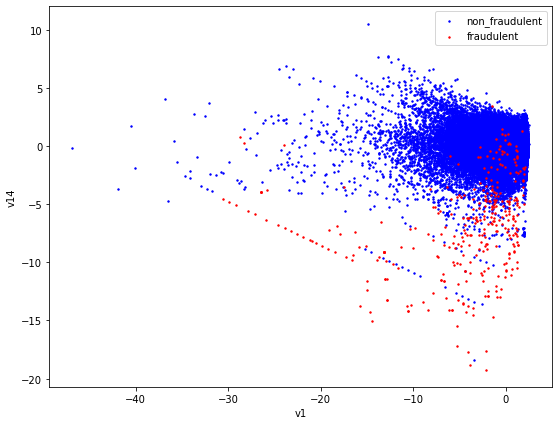

threshold range: -2.46863755072431 -190.04777610095263
train auc: 0.947002350878887 val auc: 0.932260556830421
max f1: 0.3880597014925373 threshold: -40


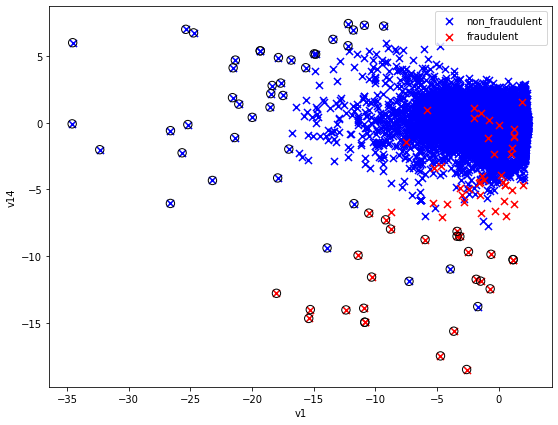

In [ ]:
### YOUR CODE HERE ###
#pick f1 and f14 first
scatter(X_train[:,1],X_train[:,14],'v1','v14')

#from f1 and f14,choose 1 component visually
v1v14_train=X_train[:,[1,14]]
v1v14_val=X_val[:,[1,14]]
gm=GaussianMixture(n_components=1,random_state=0).fit(v1v14_train)
v1v14_tscore=gm.score_samples(v1v14_train)
v1v14_vscore=gm.score_samples(v1v14_val)
v1v14_tauc=roc_auc_score(y_train,-v1v14_tscore)
v1v14_vauc=roc_auc_score(y_val,-v1v14_vscore)
print('threshold range:',max(v1v14_vscore),min(v1v14_vscore))
print('train auc:',v1v14_tauc,'val auc:',v1v14_vauc)

max_f1_v1v14,threshold_v1v14=f1_threshold(v1v14_vscore)
print('max f1:',max_f1_v1v14,'threshold:',threshold_v1v14)

scatter_outlier(X_val[:,1],X_val[:,14],'v1','v14',v1v14_vscore,threshold_v1v14)

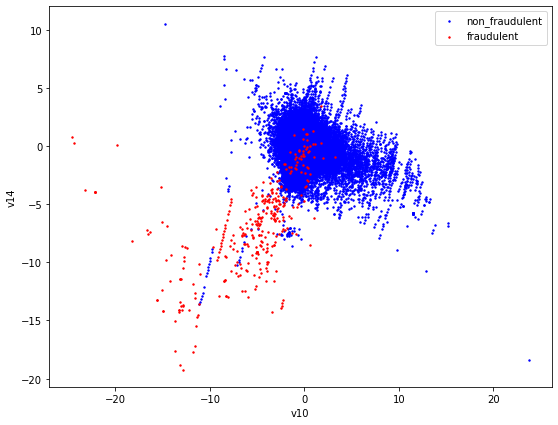

threshold range: -1.8825694871303136 -249.20560302138597
train auc: 0.9538028522657257 val auc: 0.9514752164063631
max f1: 0.3862068965517242 threshold: -40


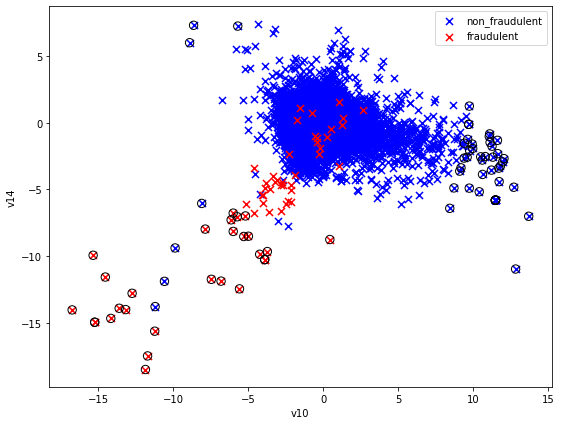

In [ ]:
#pick v10 and v14
scatter(X_train[:,10],X_train[:,14],'v10','v14')

#from f10 and f14,choose 1 component visually
v10v14_train=X_train[:,[10,14]]
v10v14_val=X_val[:,[10,14]]
gm=GaussianMixture(n_components=1,random_state=0).fit(v10v14_train)
v10v14_tscore=gm.score_samples(v10v14_train)
v10v14_vscore=gm.score_samples(v10v14_val)
v10v14_tauc=roc_auc_score(y_train,-v10v14_tscore)
v10v14_vauc=roc_auc_score(y_val,-v10v14_vscore)
print('threshold range:',max(v10v14_vscore),min(v10v14_vscore))
print('train auc:',v10v14_tauc,'val auc:',v10v14_vauc)

max_f1_v10v14,threshold_v10v14=f1_threshold(v10v14_vscore)
print('max f1:',max_f1_v10v14,'threshold:',threshold_v10v14)

scatter_outlier(X_val[:,10],X_val[:,14],'v10','v14',v10v14_vscore,threshold_v10v14)

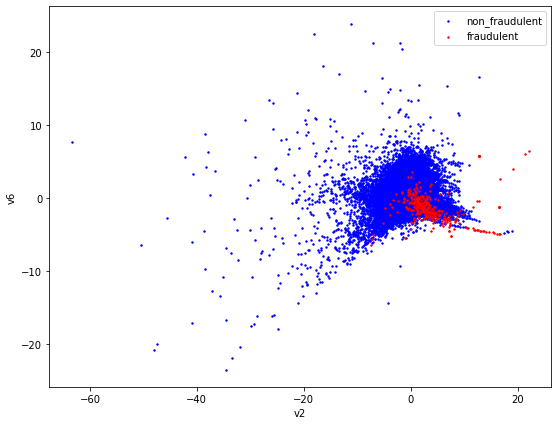

threshold range: -2.6272811040538264 -680.4316695728547
train auc: 0.8285081367586271 val auc: 0.7915822491145343
max f1: 0.07608695652173912 threshold: -14


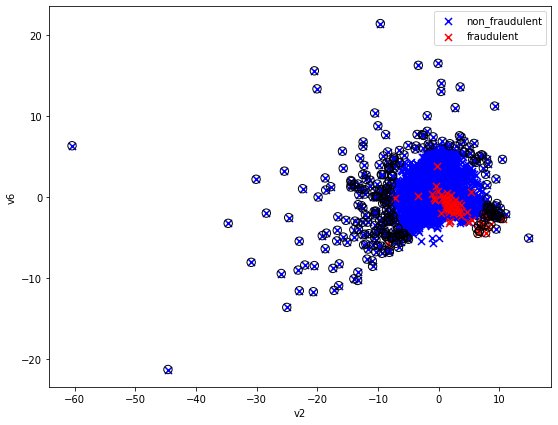

In [ ]:
#pick v2 and v6
scatter(X_train[:,2],X_train[:,6],'v2','v6')

#from f2 and f6,choose 1 component visually
v2v6_train=X_train[:,[2,6]]
v2v6_val=X_val[:,[2,6]]
gm=GaussianMixture(n_components=1,random_state=0).fit(v2v6_train)
v2v6_tscore=gm.score_samples(v2v6_train)
v2v6_vscore=gm.score_samples(v2v6_val)
v2v6_tauc=roc_auc_score(y_train,-v2v6_tscore)
v2v6_vauc=roc_auc_score(y_val,-v2v6_vscore)
print('threshold range:',max(v2v6_vscore),min(v2v6_vscore))
print('train auc:',v2v6_tauc,'val auc:',v2v6_vauc)

max_f1_v2v6,threshold_v2v6=f1_threshold(v2v6_vscore)
print('max f1:',max_f1_v2v6,'threshold:',threshold_v2v6)

scatter_outlier(X_val[:,2],X_val[:,6],'v2','v6',v2v6_vscore,threshold_v2v6)

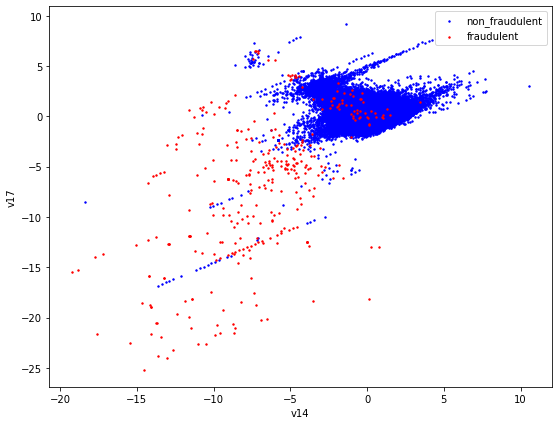

threshold range: -1.6338808276148775 -417.68498585084734
train auc: 0.9614769283917324 val auc: 0.942924286990984
max f1: 0.7007299270072992 threshold: -26


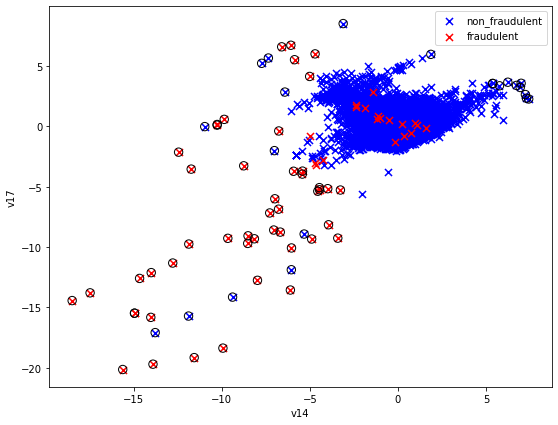

In [ ]:
#pick v14 and v17
scatter(X_train[:,14],X_train[:,17],'v14','v17')

#from f14 and f17,choose 1 component visually
v14v17_train=X_train[:,[14,17]]
v14v17_val=X_val[:,[14,17]]
gm=GaussianMixture(n_components=1,random_state=0).fit(v14v17_train)
v14v17_tscore=gm.score_samples(v14v17_train)
v14v17_vscore=gm.score_samples(v14v17_val)
v14v17_tauc=roc_auc_score(y_train,-v14v17_tscore)
v14v17_vauc=roc_auc_score(y_val,-v14v17_vscore)
print('threshold range:',max(v14v17_vscore),min(v14v17_vscore))
print('train auc:',v14v17_tauc,'val auc:',v14v17_vauc)

max_f1_v14v17,threshold_v14v17=f1_threshold(v14v17_vscore)
print('max f1:',max_f1_v14v17,'threshold:',threshold_v14v17)

scatter_outlier(X_val[:,14],X_val[:,17],'v14','v17',v14v17_vscore,threshold_v14v17)

## **Part 4: Single feature model with two Gaussian distributions. [2 Marks]**
Now we will use two different distributions for fraudulent and non-fraudulent transactions.
  1.  Fit a Gaussian distribution ($G_1$) on a feature of **non-fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  2. Fit another Gaussian distribution ($G_2$) on the same feature but for **fraudulent transactions** using ``sklearn.mixture.GaussianMixture`` when ``n_components=1``. **[0.25]**
  3. Compute the score samples ($S$) for both $G_1$ and $G_2$ on the **validation set** to get $S_1$ and $S_2$, respectively. **[0.25]**
  4. Find an optimal $c$ (a real number) that maximizes validation set F1 Score for a model such that if $S_1 < c \times S_2$, the transaction is classified as a fraud. For example, if $c=1$ we could say that if $S_2$ is greater than $S_1$, ($S_1$<$S_2$) then the transaction is a fraud (the transaction belongs to the $G_2$ distribution which represents fraudulent transactions). For start consider $c$ in $[0,10]$ with steps of 0.1, you can change this window in your experiments if needed. **[0.25]**
  5. Repeat the steps above for all the features. What is the best F1 Score that you get for training and validation? Which feature and what c? **[1]**
  best val f1:0.65 c=7.2 feature:V17
  best train f1:0.68 c=4.8 feature:v12

In [ ]:
### YOUR CODE HERE ###
index_nf=X_train[np.nonzero(y_train==0)]
index_f=X_train[np.nonzero(y_train==1)]
list_c=[]
list_f1=[]
list_train_f1=[]
for feat in range(1,29):
  nf_train=index_nf[:,feat]
  f_train=index_f[:,feat]
  val=X_val[:,feat]
  train=np.reshape(X_train[:,feat],(X_train[:,feat].shape[0],1))
  nf_train=np.reshape(nf_train,(nf_train.shape[0],1))
  f_train=np.reshape(f_train,(f_train.shape[0],1))
  val=np.reshape(val,(val.shape[0],1))
  G1=GaussianMixture(n_components=1,random_state=0).fit(nf_train)
  G2=GaussianMixture(n_components=1,random_state=0).fit(f_train)
  S1=G1.score_samples(val)
  S2=G2.score_samples(val)
  S1_train=G1.score_samples(train)
  S2_train=G2.score_samples(train)
  maxf1=0
  for c in np.arange(0,10,0.1):
    f1=f1_score(y_val,S1<c*S2)
    if maxf1<f1:
      maxf1=f1
      op_c=c
  max_train_f1=f1_score(y_train,S1_train<op_c*S2_train)
  list_c.append(op_c)
  list_f1.append(maxf1)
  list_train_f1.append(max_train_f1)

In [ ]:
index1=list_f1.index(max(list_f1))
index2=list_train_f1.index(max(list_train_f1))
print('best val f1:',max(list_f1),'c:',list_c[index1],'feature:',features[index1])
print('best train f1:',max(list_train_f1),'c:',list_c[index2],'feature:',features[index2])

best val f1: 0.6545454545454547 c: 7.2 feature: V17
best train f1: 0.6830870279146141 c: 4.800000000000001 feature: V12


## **Part 5: Multivariate and Mixture of Gaussians Distribution [4 Marks]**
We now want to build an outlier detection model that performs well in terms of F1 score. To design your model, you can benefit from:

*   No restrictions on the number of features - use as few or as many as you want! (multivariate). 
*   To fit your model, you can take advantage of the Gaussian mixture model, where you can set the number of components [help](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).
*   You can choose to fit your Gaussians on non-fraudulent transactions or to both classes. 


It is up to you how to design your model. Try at least 10 different models and report the AUC for both training and validation sets (if applicable) and the best F1 score for both training and validation sets for each model. What kind of model works better? How many features are best (and which ones)? How many Gaussians? How many components? Summarize your findings with tables or plots. **[4]**

The best model I found is two gaussian models, 5 features(v14,v17,v10,v4,v12) and 6 components in G2, 1 component in G1.

**HINT !**

You might want to try a two-gaussian model, multiple features, a single component for the valid transaction, and multiple components for fraudulent ones! Why does it make sense to have multiple components for fraudulent transactions?

fraudulent transactions always have different situations like different ways of fraud which the features obey different distributions.From the distribution graph we can also find fraud class of many features have combination distributions and multiple components distribution may be better to describe it.

In [ ]:
list_f1=[]
df_model_train=np.zeros(10)
df_model_val=np.zeros(10)
list_c_op=[]
for i in range(1,11):
  feature=[14,17,10,4,12,11,16,3,28,18]
  nf_train=index_nf[:,feature[0:i]]
  f_train=index_f[:,feature[0:i]]
  train=X_train[:,feature[0:i]]
  val=X_val[:,feature[0:i]]
  n=6 #by experiment,choose 6 as number of components
  G1=GaussianMixture(n_components=1,random_state=0).fit(nf_train)
  G2=GaussianMixture(n_components=6,random_state=0).fit(f_train)
  S1_train=G1.score_samples(train)
  S2_train=G2.score_samples(train)
  S1_val=G1.score_samples(val)
  S2_val=G2.score_samples(val)
  maxf1_val=0
  for c in np.arange(0,10,0.1):
    f1_val=f1_score(y_val,S1_val<c*S2_val)
    if maxf1_val<f1_val:
      maxf1_val=f1_val
      c_op=c
  f1_train=f1_score(y_train,S1_train<c_op*S2_train)
  list_c_op.append(c_op)
  df_model_train[i-1]=f1_train
  df_model_val[i-1]=maxf1_val

In [ ]:
index_name=['v14','v14,v17','v14,v17,v10','v14,v17,v10,v4','v14,v17,v10,v4,v12','v14,v17,v10,v4,v12,v11','v14,v17,v10,v4,v12,v11,v16','v14,v17,v10,v4,v12,v11,v16,v3',
        'v14,v17,v10,v4,v12,v11,v16,v3,v28','v14,v17,v10,v4,v12,v11,v16,v3,v28,v18']
df_train=pd.DataFrame(data=df_model_train,columns=['n_components=6'],index=index_name)
df_val=pd.DataFrame(data=df_model_val,columns=['n_components=6'],index=index_name)
best_f1_train=df_train.values.max()
best_f1_val=df_val.values.max()
print('best train f1 score:',best_f1_train,'n_componets:',6,'feature:','v14,v17,v10,v4,v12,v11')
print('best val f1 score:',best_f1_val,'n_componets:',6,'feature:','v14,v17,v10,v4,v12')
display(df_train)
display(df_val)

best train f1 score: 0.7967032967032966 n_componets: 6 feature: v14,v17,v10,v4,v12,v11
best val f1 score: 0.8124999999999999 n_componets: 6 feature: v14,v17,v10,v4,v12


,n_components=6
v14,0.632873
"v14,v17",0.750357
"v14,v17,v10",0.793343
"v14,v17,v10,v4",0.763780
"v14,v17,v10,v4,v12",0.791724
"v14,v17,v10,v4,v12,v11",0.796703
"v14,v17,v10,v4,v12,v11,v16",0.780690
"v14,v17,v10,v4,v12,v11,v16,v3",0.786974
"v14,v17,v10,v4,v12,v11,v16,v3,v28",0.791837
"v14,v17,v10,v4,v12,v11,v16,v3,v28,v18",0.794558


,n_components=6
v14,0.637168
"v14,v17",0.737705
"v14,v17,v10",0.793651
"v14,v17,v10,v4",0.800000
"v14,v17,v10,v4,v12",0.812500
"v14,v17,v10,v4,v12,v11",0.806202
"v14,v17,v10,v4,v12,v11,v16",0.796875
"v14,v17,v10,v4,v12,v11,v16,v3",0.806202
"v14,v17,v10,v4,v12,v11,v16,v3,v28",0.806202
"v14,v17,v10,v4,v12,v11,v16,v3,v28,v18",0.806202


## **Part 6: Evaluating performance on test set: [1 Mark]**
**Which model worked better?** Pick your best model among all models and apply it to your test set. Report the F1 Score, precision and recall on the test set. **[1]**

F1_score: 0.814 precicion: 0.782 recall: 0.85

In [ ]:
### YOUR CODE HERE ###
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
feature=[4,10,12,14,17]
final_X_test=X_test[:,feature]
nf_train=index_nf[:,feature]
f_train=index_f[:,feature]
G1=GaussianMixture(n_components=1,random_state=0).fit(nf_train)
G2=GaussianMixture(n_components=6,random_state=0).fit(f_train)
S1=G1.score_samples(final_X_test)
S2=G2.score_samples(final_X_test)
pre=S1<list_c_op[4]*S2
F1_score=f1_score(y_test,pre)
precicion=precision_score(y_test,pre)
recall=recall_score(y_test,pre)
print('F1_score:',F1_score,'precicion:',precicion,'recall:',recall)

F1_score: 0.8143712574850299 precicion: 0.7816091954022989 recall: 0.85


## **Part 7: Is Gaussian the only useful distribution? [1 Mark]**

Search for other distributions that could be used to model the data. How popular are they? Is there a specific situation where a distribution works better? How can we find a suitable distribution to model our data? Do not forget to include your references. 




T-distribution may be the most important and popular distribution in statistics. It's often used to hypothesis testing and decide the difference between mean values. Bernoulli’s Distribution is a simple but widly used distribution which used in two outcomes and one trial cases. There are also many other classic distributions like binominal distribution for repeated two outcomes trial and poisson distribution for the probability of a given number of events that take place in a fixed time period or space. 
To find a suitable distribution, we should find the properties of the data and how a single event happens in our dataset. Hence normal distribution is suitable for our data.

Reference:

https://www.analyticssteps.com/blogs/10-types-statistical-data-distribution-models

https://en.wikipedia.org/wiki/Poisson_distribution

https://towardsdatascience.com/anomaly-detection-for-dummies-15f148e559c1